# 1. Introdução

# 2. Os Dados

## Extração dos Dados e Análise Exploratória

Loads a dataset with product data from a specified path available in the environment variable DATASET_PATH

In [34]:
import os
import re
import time
import pickle
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from stop_words import get_stop_words

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from config.config import *
from processing.data_management import *

import nltk
nltk.download('rslp')

import dotenv
dotenv.load_dotenv()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package rslp to /home/raffael/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [2]:
TRAINING_DIR = os.path.dirname(os.path.abspath("__file__"))
BASE_DIR = os.path.dirname(TRAINING_DIR)
DATASET_PATH = os.path.join(BASE_DIR, os.getenv("DATASET_PATH"))

In [3]:
df = load_data(os.path.join(BASE_DIR,DATASET_PATH))
df.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


In [4]:
df['creation_date'] = pd.to_datetime(df['creation_date'], format="%Y-%m-%d %H:%M:%S")

In [35]:
#TODO
#IMPROVE EDA

In [5]:
df.category.unique()

array(['Decoração', 'Papel e Cia', 'Outros', 'Bebê', 'Lembrancinhas',
       'Bijuterias e Jóias'], dtype=object)

In [6]:
missing = df.isnull().mean()
missing = missing[missing > 0]
missing 

concatenated_tags    0.000053
weight               0.001526
order_counts         0.529079
dtype: float64

In [7]:
df_dummy = pd.concat([df,pd.get_dummies(df['category'])],axis=1)
df_dummy.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,...,minimum_quantity,view_counts,order_counts,category,Bebê,Bijuterias e Jóias,Decoração,Lembrancinhas,Outros,Papel e Cia
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,...,4,244,NaN,Decoração,0,0,1,0,0,0
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,...,5,124,NaN,Papel e Cia,0,0,0,0,0,1
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,...,1,59,NaN,Outros,0,0,0,0,1,0
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,...,1,180,1.0,Bebê,1,0,0,0,0,0
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,...,6,34,NaN,Decoração,0,0,1,0,0,0


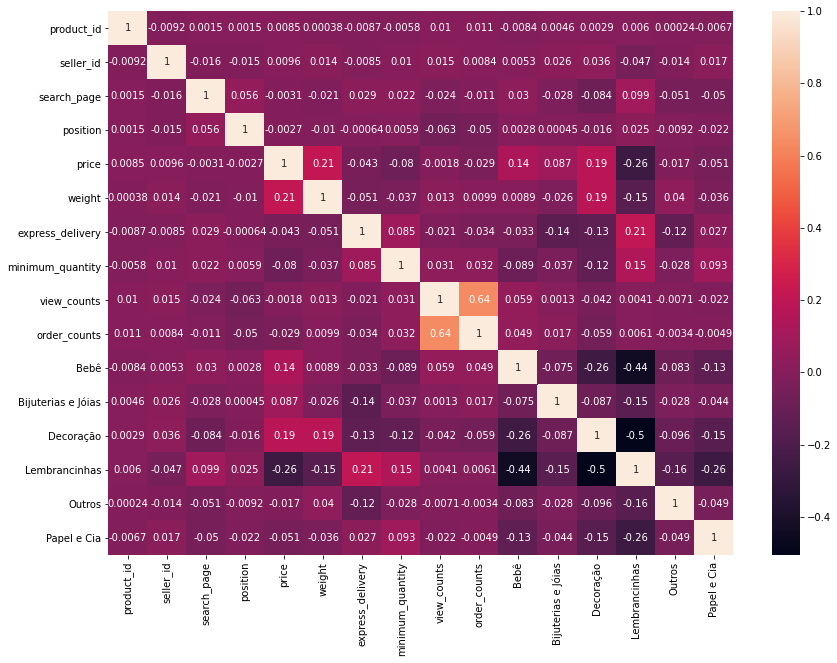

In [8]:
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df_dummy.corr(), annot=True, ax=ax);

# 3. Pipeline de Treinamento

* Remover colunas que não importam para o modelo
* Tratar dados faltantes
* Remover caracteres acentuados
* Remover caracteres especiais
* Descaptalizar palavras
* Remover stop words
* Lemmatizar
* Tokenizar
* Featurização do corpus

## 3.1 Pipeline de Pré-processamento

Processes the dataset to use it for training and validation

### 3.1.1 Pré-processamento das variáveis não-textuais

In [9]:
def features_remover(df, variables):
    X = df.copy()
    return X.drop(labels=variables, axis=1)

def remove_null_rows(df):
    X = df.copy()
    return X.dropna(axis=0)

In [10]:
df_train = df.copy()

df_train = features_remover(df, FEATURES_TO_DROP)
df_train = remove_null_rows(df_train).reset_index(drop=True)
df_train.shape

(37940, 8)

### 3.1.2 Pré-processamento das variáveis textuais

In [11]:
def accents_remover(text):
    #https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return str(text)

def special_char_remover(text):
    return re.sub('[^A-Za-z0-9 ]+', '', text)

def text_to_lowercase(text):    
    return str.lower(text)

def stop_words_remover(text, language='portuguese'):
    text = ' '.join([word for word in text.split() if word not in (get_stop_words(language))])
    return text

#portuguese stemmer
stemmer = nltk.stem.RSLPStemmer()
def text_stemmer(text):
    words_list = [stemmer.stem(word) for word in text.split()]
    return ' '.join(words_list)

def text_normalizer(text, stem=True):
    
    text = text_to_lowercase(text)
    text = accents_remover(text)
    text = special_char_remover(text)
    text = stop_words_remover(text)
    
    if stem:
        text = text_stemmer(text)
        
    return text

In [12]:
df_train['query'] = df_train['query'].apply(lambda x: text_normalizer(x, stem=False))
df_train['title'] = df_train['title'].apply(lambda x: text_normalizer(x, stem=False))
df_train['concatenated_tags'] = df_train['concatenated_tags'].apply(lambda x: text_normalizer(x, stem=False))
df_train.head()

,query,title,concatenated_tags,price,weight,express_delivery,minimum_quantity,category
0,espirito santo,mandala espirito santo,mandala mdf,171.890000,1200.0,1,4,Decoração
1,cartao visita,cartao visita,cartao visita panfletos tag adesivos copos lon...,77.670000,8.0,1,5,Papel e Cia
2,expositor esmaltes,organizador expositor p 70 esmaltes,expositor,73.920006,2709.0,1,1,Outros
3,medidas lencol berco americano,jogo lencol berco estampado,t jogo lencol menino lencol berco,118.770004,0.0,1,1,Bebê
4,adesivo box banheiro,adesivo box banheiro,adesivo box banheiro,191.810000,507.0,1,6,Decoração


### 3.1.3 Feature Engineering

* Concatenar query e tags: por que?
* Escalar as variáveis 'price', 'weight', 'minimum_quantity'
* Featurizar as variáveis textuais: BoW e TF-IDF

In [13]:
df_train.loc[:,'query_tags'] = df_train['query'] + str(' ') + df_train['concatenated_tags']
df_train = df_train.drop(labels=['query', 'concatenated_tags'], axis=1)
df_train.head()

,title,price,weight,express_delivery,minimum_quantity,category,query_tags
0,mandala espirito santo,171.890000,1200.0,1,4,Decoração,espirito santo mandala mdf
1,cartao visita,77.670000,8.0,1,5,Papel e Cia,cartao visita cartao visita panfletos tag ades...
2,organizador expositor p 70 esmaltes,73.920006,2709.0,1,1,Outros,expositor esmaltes expositor
3,jogo lencol berco estampado,118.770004,0.0,1,1,Bebê,medidas lencol berco americano t jogo lencol m...
4,adesivo box banheiro,191.810000,507.0,1,6,Decoração,adesivo box banheiro adesivo box banheiro


In [14]:
df_train_ = df_train[['title', 'query_tags', 'category']]
df_train_.head()

,title,query_tags,category
0,mandala espirito santo,espirito santo mandala mdf,Decoração
1,cartao visita,cartao visita cartao visita panfletos tag ades...,Papel e Cia
2,organizador expositor p 70 esmaltes,expositor esmaltes expositor,Outros
3,jogo lencol berco estampado,medidas lencol berco americano t jogo lencol m...,Bebê
4,adesivo box banheiro,adesivo box banheiro adesivo box banheiro,Decoração


In [15]:
#MODEL REPRODUCTIBILITY
np.random.seed(SEED)

In [16]:
#GETTING FEATURES AND LABELS
X = df_train_.drop('category', axis=1)
y = df_train_['category']

#SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

#BAG OF WORDS FOR TRAINIG DATA
cv_train = CountVectorizer(lowercase=False)
X_train_counts = cv_train.fit_transform(X_train.title, X_train.query_tags)

#BAG OF WORDS FOR TEST DATA
cv_test = CountVectorizer(vocabulary=cv_train.get_feature_names())
X_test_counts = cv_test.fit_transform(X_test.title, X_test.query_tags)

#TF-IDF FOR TRAINING AND TEST DATA
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

#LABEL ENCODER
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## 3.2 Modelagem

* Bag of Words
* TF-IDF

Specifies a model to handle the categorization problem

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.metrics import f1_score, confusion_matrix, plot_roc_curve, roc_curve, auc

from sklearn.model_selection import RandomizedSearchCV

In [18]:
clf = [
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression(random_state=SEED)),
    ('Decision Tree', DecisionTreeClassifier(random_state=SEED)),
    ('Random Forest', RandomForestClassifier(random_state=SEED,n_estimators=50, n_jobs=-1)),
    ('K-Nearest Neightbors', KNeighborsClassifier()),
    
    ('XGBoost Classifier', XGBClassifier(random_state=SEED,
                                         use_label_encoder=False, 
                                         eval_metric='logloss',
                                         predictor='gpu_predictor')),
    
    ('LightGBM', LGBMClassifier(random_state=SEED, objective='multiclass'))
]

In [19]:
cv = KFold(n_splits=10, shuffle=False)

def train_models(classifiers, X, y, cv=cv):
    
    models_dict = {}
    for clf in classifiers:

        print(f"Treinando o classificador {clf[0]}...", end="")
        
        accu = []
        recall = []
        f1_ = []
        precision = []
        fit_time_list = []
        pred_time_list = []
        for train_idx, test_idx in cv.split(X, y):

            X_train = X[train_idx].astype('float32')
            X_test = X[test_idx].astype('float32')
            y_train = y[train_idx]
            y_test = y[test_idx]
            
            start_fit = time.time()
            clf[1].fit(X_train, y_train)
            fit_time = time.time() - start_fit
            
            start_pred = time.time()
            pred = clf[1].predict(X_test)
            pred_time = time.time() - start_pred
            
            accu.append(accuracy_score(y_test, pred))
            recall.append(recall_score(y_test, pred, average='macro'))
            f1_.append(f1_score(y_test, pred, average='macro'))
            precision.append(precision_score(y_test, pred, average='macro'))
            fit_time_list.append(fit_time)
            pred_time_list.append(pred_time)

        models_dict[clf[0]] = {'model':clf[1],
                               'accuracy': np.mean(accu),
                               'recall': np.mean(recall),
                               'precision': np.mean(precision), 
                               'f1-score': np.mean(f1_), 
                               'fit_time': np.mean(fit_time_list), 
                               'pred_time': np.mean(pred_time_list)}

        print(f"ok. Tempo de treino: {np.sum(fit_time_list)} segundos\n")

        print(f"Resultados do classificador {clf[0]}:\n")
        print(f"Accuracy: {models_dict[clf[0]]['accuracy']}")
        print(f"Recall: {models_dict[clf[0]]['recall']}")
        print(f"Precision Score: {models_dict[clf[0]]['precision']}")
        print(f"F1 Score: {models_dict[clf[0]]['f1-score']}")
        print(f"Time to fit: {models_dict[clf[0]]['fit_time']}")
        print(f"Time to predict: {models_dict[clf[0]]['pred_time']}")
        print('-'*50)
    
    return models_dict

### 3.2.1 Treinando modelos com texto featurizados via Bag of Words

In [20]:
models_dict_counts = train_models(classifiers=clf, X=X_train_counts, y=y_train_enc, cv=cv)

Treinando o classificador Multinomial Naive Bayes...ok. Tempo de treino: 0.07517743110656738 segundos

Resultados do classificador Multinomial Naive Bayes:

Accuracy: 0.8529257585525045
Recall: 0.7565495916309487
Precision Score: 0.8453446242653697
F1 Score: 0.7911695387053574
Time to fit: 0.0075177431106567385
Time to predict: 0.0004287242889404297
--------------------------------------------------
Treinando o classificador Logistic Regression...ok. Tempo de treino: 21.18723177909851 segundos

Resultados do classificador Logistic Regression:

Accuracy: 0.8735831634878982
Recall: 0.7918536564375167
Precision Score: 0.8716563868053726
F1 Score: 0.824185205978818
Time to fit: 2.118723177909851
Time to predict: 0.0005312919616699219
--------------------------------------------------
Treinando o classificador Decision Tree...ok. Tempo de treino: 10.317651748657227 segundos

Resultados do classificador Decision Tree:

Accuracy: 0.8697944273332856
Recall: 0.8145350745982689
Precision Score: 

### 3.2.2 Treinando modelos com texto featurizados via TF-IDF

In [21]:
models_dict_tfidf = train_models(classifiers=clf, X=X_train_tfidf, y=y_train_enc, cv=cv)

Treinando o classificador Multinomial Naive Bayes...ok. Tempo de treino: 0.05191397666931152 segundos

Resultados do classificador Multinomial Naive Bayes:

Accuracy: 0.8352335510393673
Recall: 0.6420620034999472
Precision Score: 0.9012604463322337
F1 Score: 0.6986332309176817
Time to fit: 0.005191397666931152
Time to predict: 0.0003300189971923828
--------------------------------------------------
Treinando o classificador Logistic Regression...ok. Tempo de treino: 23.632505893707275 segundos

Resultados do classificador Logistic Regression:

Accuracy: 0.8669610690386422
Recall: 0.7585284461717697
Precision Score: 0.8762214341282248
F1 Score: 0.8018041932069879
Time to fit: 2.3632505893707276
Time to predict: 0.000884389877319336
--------------------------------------------------
Treinando o classificador Decision Tree...ok. Tempo de treino: 14.355185747146606 segundos

Resultados do classificador Decision Tree:

Accuracy: 0.8726278724498766
Recall: 0.8172775219571218
Precision Score:

### 3.2.3 Escolha

* RF/TF-IDF
* Tempo de treino irrelevante
* F1-Score ~ 85%
* Tempo de predição ~ 20ms

## 3.3 Validação do Modelo

Generates metrics about the model accuracy (precision, recall, F1, etc.) for **each category** and exports them to a specified path available in the environment variable METRICS_PATH

In [31]:
def train_single_model(X_train, 
                       y_train, 
                       X_test, 
                       y_test, 
                       model=models_dict_tfidf['Random Forest']['model']):
    
    #train model
    print("Treinando o modelo escolhido...", end="")
    start_fit = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start_fit
    print(f"ok. Treinado em {fit_time} segundos\n")

    #predict on hold-out sample
    start_pred = time.time()
    pred = model.predict(X_test)
    pred_time = time.time() - start_pred
    
    print("Resultados:")
    print(f"Accuracy: {accuracy_score(y_test, pred)}")
    print(f"Recall: {recall_score(y_test, pred, average='macro')}")
    print(f"Precision: {precision_score(y_test, pred, average='macro')}")
    print(f"F1 Score: {f1_score(y_test, pred, average='macro')}")
    print(f"Time to Fit: {fit_time}")
    print(f"Time to Predict: {pred_time}")

    chosen_model_dict = {
        'accuracy':accuracy_score(y_test, pred),
        'recall':recall_score(y_test, pred, average='macro'),
        'precision':precision_score(y_test, pred, average='macro'),
        'f1-score':f1_score(y_test, pred, average='macro'), 
        'fit_time':fit_time, 'pred_time':pred_time    
    }
    
    return model, chosen_model_dict

In [32]:
chosen_model_dict = {}
fitted_model, chosen_model_dict['RF/TFIDF'] = train_single_model(X_train_tfidf, y_train_enc, X_test_tfidf, y_test_enc)

Treinando o modelo escolhido...ok. Treinado em 2.467167615890503 segundos

Resultados:
Accuracy: 0.8945703742751713
Recall: 0.8264786695531995
Precision: 0.8926971901432076
F1 Score: 0.8547817590170209
Time to Fit: 2.467167615890503
Time to Predict: 0.03974485397338867


In [29]:
#TODO
#EXPORTAR AS METRICAS PARA O ARQUIVO DE TEXTO

## 3.4 Persistindo o Modelo

Exports a candidate model to a specified path available in the environment variable MODEL_PATH

In [33]:
files_to_persist = {
    'Count Vectorizer':cv_train,
    'TF-IDF':tfidf_transformer,
    'Label Encoder':le,
    #'Scaler':scaler,
    'Model':fitted_model,
    'Model Metrics':chosen_model_dict['RF/TFIDF']
}

In [ ]:
#TODO
#with open(MODEL_PATH, "wb") as f:
#    pickle.dump(files_to_persist, f)

# 4. Conclusão